# Given the stock information of at least the past 5 days of all companies, try to predict the closing price of one company on a particular day

# Load libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import root_mean_squared_error

# Load dataset and process Date

In [38]:
# Load the dataset
data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\train_data.csv")

# Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Check for NaT values after conversion
if data['Date'].isnull().any():
    print("There are unparseable dates:")
    print(data[data['Date'].isnull()])

C:\Users\Admin\AppData\Local\Temp\ipykernel_20404\4089226232.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\train_data.csv")


# Retrieve the relevant information - instead of all 500 companies, use the companies belonging in the same industry as target company

In [39]:
# Define the company of interest
target_company = 'QCOM'

# Ensure we have data for the target company
if target_company not in data['Symbol'].unique():
    raise ValueError(f"{target_company} is not in the dataset.")

# Filter data for the target company
target_data = data[data['Symbol'] == target_company].set_index('Date')

# Ensure we have enough data for the target company
if len(target_data) < 5:
    raise ValueError("Not enough data to predict. At least 5 days are required.")

# Get the industry of the target company
target_industry = target_data['GICS Sector'].iloc[0]

# Filter data for companies in the same industry
industry_data = data[data['GICS Sector'] == target_industry]

# Get the last n days of data for the target company
last_n_days_target = target_data['Close'].tail(200)

# Get the last n days of data for all companies in the same industry
last_n_days_industry = industry_data[industry_data['Date'].isin(last_n_days_target.index)]
avg_last_n_days = last_n_days_industry.groupby('Date')['Close'].mean()

print(target_data['GICS Sector'])
print(avg_last_n_days)


Date
2020-09-30    Information Technology
2020-10-01    Information Technology
2020-10-02    Information Technology
2020-10-05    Information Technology
2020-10-06    Information Technology
                       ...          
2021-12-27    Information Technology
2021-12-28    Information Technology
2021-12-29    Information Technology
2021-12-30    Information Technology
2021-12-31    Information Technology
Name: GICS Sector, Length: 317, dtype: object
Date
2021-03-19    181.825149
2021-03-22    184.209535
2021-03-23    181.833584
2021-03-24    180.070883
2021-03-25    180.477956
                 ...    
2021-12-27    236.958801
2021-12-28    235.220625
2021-12-29    235.828601
2021-12-30    234.347699
2021-12-31    233.736999
Name: Close, Length: 200, dtype: float64


# Perform rolling-window cross validation

In [40]:
# Define rolling window parameters
n = len(avg_last_n_days)
train_size = int(n * 0.8)
test_size = n - train_size
roll_window = 1  # Use a smaller value like 1 for rolling windows

# library ExponentialSmoothing automatically finds optimal alpha, beta and gamma parameters but we still need to determine if parameters trend and seasonal are addictive or multiplicative

In [41]:
# Define parameter combinations
param_combinations = [
    ('add', 'add'),
    ('add', 'mul'),
    ('mul', 'add'),
    ('mul', 'mul')
]

results = []

# Rolling window cross-validation
for start in range(0, test_size, roll_window):
    train = avg_last_n_days.iloc[:train_size + start]
    test = avg_last_n_days.iloc[train_size + start: train_size + start + roll_window]
    
    for trend, seasonal in param_combinations:
        try:
            model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=7)
            fit = model.fit()
            
            # Forecast the next value(s)
            forecast = fit.forecast(roll_window)
            
            # Calculate RMSE
            rmse = root_mean_squared_error(test, forecast)  
            
            results.append({
                'trend': trend,
                'seasonal': seasonal,
                'start': start,
                'rmse': rmse,
            })
        except Exception as e:
            print(f"Error fitting model with trend={trend} and seasonal={seasonal}: {e}")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Summarize results
summary = results_df.groupby(['trend', 'seasonal']).agg({'rmse': 'mean'}).reset_index()
print(summary)

# Find the row with the minimum RMSE
lowest_rmse_row = summary.loc[summary['rmse'].idxmin()]

# Extract the trend and seasonal values
lowest_trend = lowest_rmse_row['trend']
lowest_seasonal = lowest_rmse_row['seasonal']

print(f"Lowest RMSE: {lowest_rmse_row['rmse']}")
print(f"Trend: {lowest_trend}, Seasonal: {lowest_seasonal}")

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

  trend seasonal      rmse
0   add      add  2.884564
1   add      mul  2.888477
2   mul      add  2.882423
3   mul      mul  2.890015
Lowest RMSE: 2.8824226915688143
Trend: mul, Seasonal: add


c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Us

# Input the trend and seasonal, that gives the lowest RMSE found during cross validation, into Holt-Winter's model

In [42]:
# Fit the Holt-Winters model
model = ExponentialSmoothing(
    avg_last_n_days,
    trend=lowest_trend,
    seasonal=lowest_seasonal,
    seasonal_periods=7  # weekly seasonality
).fit()

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


# Forecast using model and visualise Holt-Winter's smoothed values, actual values and forecast

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


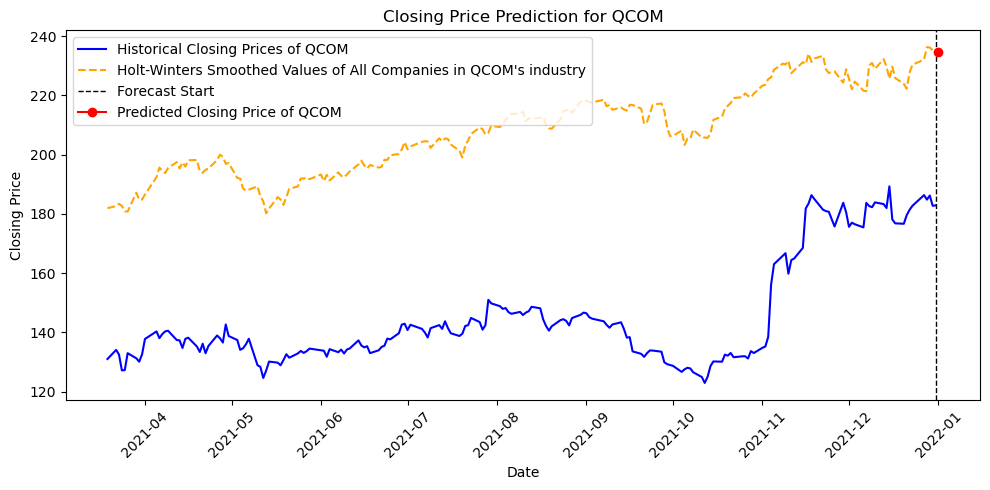

Predicted Closing Price for QCOM on the next day: 234.4647430182922
RMSE between smoothed values and actual closing prices: 64.03531679732122
MAPE between smoothed values and actual closing prices: 44.44%


In [46]:
# Forecast the next day's closing price
forecast = model.forecast(steps=1)

# Prepare data for visualization
smoothed_values = model.fittedvalues

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(last_n_days_target.index, last_n_days_target, label=f'Historical Closing Prices of {target_company}', color='blue')
plt.plot(smoothed_values.index, smoothed_values, label= f"Holt-Winters Smoothed Values of All Companies in {target_company}'s industry", color='orange', linestyle='--')
plt.axvline(x=last_n_days_target.index[-1], color='black', linewidth=1, linestyle='--', label='Forecast Start')
plt.plot(last_n_days_target.index[-1] + pd.DateOffset(days=1), forecast, marker='o', label=f'Predicted Closing Price of {target_company}', color='red')
plt.title(f'Closing Price Prediction for {target_company}')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the predicted closing price
print(f'Predicted Closing Price for {target_company} on the next day: {forecast.iloc[0]}')

# Calcualte RMSE between actual values and smoothed values
rmse = root_mean_squared_error(last_n_days_target.values, smoothed_values.values)
print(f"RMSE between smoothed values and actual closing prices: {rmse}")

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((last_n_days_target.values - smoothed_values.values) / last_n_days_target.values)) * 100
print(f'MAPE between smoothed values and actual closing prices: {mape:.2f}%')


# Perform same operations on same company on TEST set

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


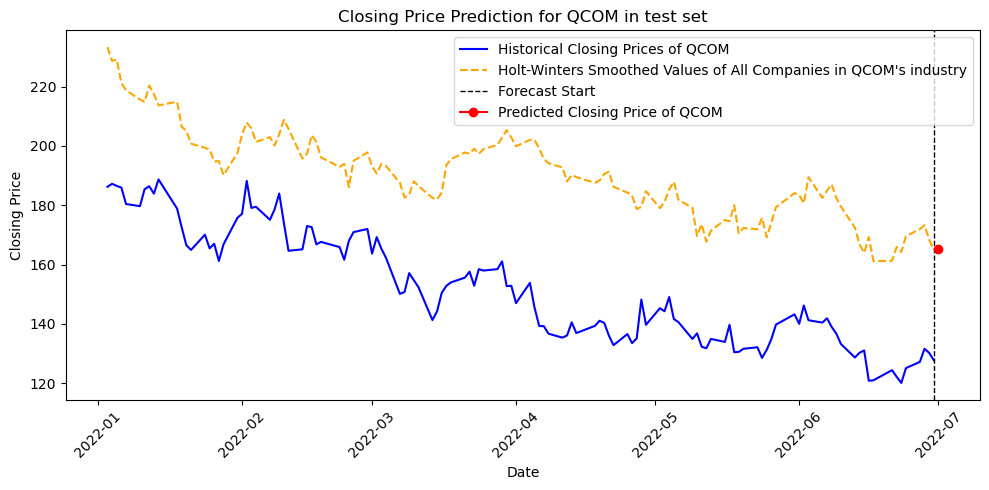

Predicted Closing Price for QCOM on the next day: 165.12136992069085
RMSE between smoothed values and actual closing prices: 39.70380176787792
MAPE between smoothed values and actual closing prices: 26.28%


In [44]:
# Load the dataset
test_data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\test_data.csv")

# Convert 'Date' to datetime
test_data['Date'] = pd.to_datetime(test_data['Date'])

# Check for NaT values after conversion
if test_data['Date'].isnull().any():
    print("There are unparseable dates:")
    print(test_data[test_data['Date'].isnull()])

# Define the company of interest
test_target_company = 'QCOM'

# Ensure we have data for the target company
if test_target_company not in test_data['Symbol'].unique():
    raise ValueError(f"{test_target_company} is not in the dataset.")

# Filter data for the target company
test_target_data = test_data[test_data['Symbol'] == test_target_company].set_index('Date')

# Ensure we have enough data for the target company
if len(test_target_data) < 5:
    raise ValueError("Not enough data to predict. At least 5 days are required.")

# Get the industry of the target company
test_target_industry = test_target_data['GICS Sector'].iloc[0]

# Filter data for companies in the same industry
test_industry_data = test_data[test_data['GICS Sector'] == test_target_industry]

# Get the last n days of data for the target company
test_last_n_days_target = test_target_data['Close'].tail(150)

# Get the last n days of data for all companies in the same industry
test_last_n_days_industry = test_industry_data[test_industry_data['Date'].isin(test_last_n_days_target.index)]
test_avg_last_n_days = test_last_n_days_industry.groupby('Date')['Close'].mean()

# Fit the Holt-Winters model using trend, seasonal and seasonality obtained during training
test_model = ExponentialSmoothing(
    test_avg_last_n_days,
    trend=lowest_trend,
    seasonal=lowest_seasonal,
    seasonal_periods=7  # weekly seasonality
).fit()

# Forecast the next day's closing price
test_forecast = test_model.forecast(steps=1)

# Prepare data for visualization
test_smoothed_values = test_model.fittedvalues

# Calcualte RMSE between actual values and smoothed values
test_rmse = root_mean_squared_error(test_last_n_days_target.values, test_smoothed_values.values)

# Calculate MAPE
test_mape = np.mean(np.abs((test_last_n_days_target.values - test_smoothed_values.values) / test_last_n_days_target.values)) * 100


# Visualization
plt.figure(figsize=(10, 5))
plt.plot(test_last_n_days_target.index, test_last_n_days_target, label=f'Historical Closing Prices of {test_target_company}', color='blue')
plt.plot(test_smoothed_values.index, test_smoothed_values, label= f"Holt-Winters Smoothed Values of All Companies in {test_target_company}'s industry", color='orange', linestyle='--')
plt.axvline(x=test_last_n_days_target.index[-1], color='black', linewidth=1, linestyle='--', label='Forecast Start')
plt.plot(test_last_n_days_target.index[-1] + pd.DateOffset(days=1), test_forecast, marker='o', label=f'Predicted Closing Price of {test_target_company}', color='red')
plt.title(f'Closing Price Prediction for {test_target_company} in test set')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the predicted closing price
print(f'Predicted Closing Price for {test_target_company} on the next day: {test_forecast.iloc[0]}')
print(f"RMSE between smoothed values and actual closing prices: {test_rmse}")
print(f'MAPE between smoothed values and actual closing prices: {test_mape:.2f}%')

